In [1]:
from dolfin import *
import time
import ufl
from matplotlib import pyplot as plt
set_log_level(50)
%matplotlib inline

/opt/anaconda3/envs/fenicsproject/lib/python3.10/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):


In [ ]:
safeSqrt = lambda x: sqrt(x + DOLFIN_EPS)
epsilon = lambda u: sym(grad(u))
sigma = lambda u, lmbda, mu: 2.0 * mu * epsilon(u) + lmbda * tr(epsilon(u)) * Identity(2)
psi = lambda u, lmbda, mu: lmbda / 2.0 * (tr(epsilon(u))**2) + mu * tr(epsilon(u) * epsilon(u))

def principal_tensor(t):
    eig1 = 0.5 * (tr(t) + safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    eig2 = 0.5 * (tr(t) - safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    return as_tensor([[eig1, 0], [0, eig2]])

def applyElementwise(f, T, dim):
    sh = ufl.shape(T)
    if len(sh) == 0:
        return f(T)
    fT = []
    for i in range(0, sh[0]):
        fT += [applyElementwise(f, T[i, i], dim)]
    return as_tensor(fT)

def psi_plus(u, lmbda, mu):
    principal_strain = principal_tensor(epsilon(u))
    tr_pr_strain = tr(principal_strain)
    strain_plus = applyElementwise(lambda x: 0.5 * (abs(x) + x), principal_strain, 2)
    tr_pr_str_plus = applyElementwise(lambda x: 0.5 * (abs(x) + x), tr_pr_strain, 2)
    si_plus = lmbda / 2.0 * (tr_pr_str_plus ** 2) + mu * (dot(strain_plus, strain_plus))
    return si_plus

def reaction_force(unew, pnew, mf, lmbda, mu, marker):
    ds = Measure("ds")(subdomain_data=mf)
    n = FacetNormal(unew.function_space().mesh())
    traction = dot(sigma(unew, lmbda, mu), n)
    fy = (1-pnew)**2 * traction[1] * ds(marker)
    force = assemble(fy)
    return force

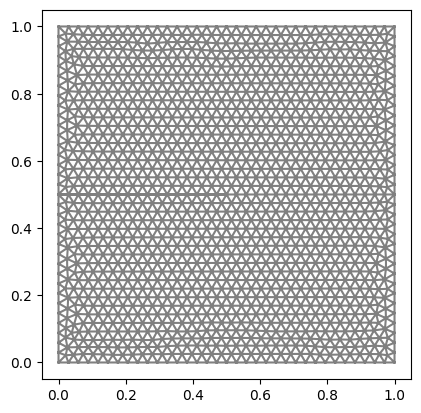

In [3]:
mesh = Mesh()
with XDMFFile("mesh/mode1_crack.xdmf") as infile:
    infile.read(mesh)
plot(mesh)

In [4]:
# -------------------------------------------------------------------------------------------------
# DEFINE MATERIAL ---------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------
E0 = 210e3  # MPa
nu = 0.3
Gc = 2.7  # MPa
l = 0.01
# -------------------------------------------------------------------------------------------------
# DEFINE SIMULATION -------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------
max_disp = 0.008
num_steps = 80*5
start_time = 0.0
end_time = 1.0
dt = (end_time - start_time) / num_steps
toll = 1e-5
is_plane_stress = False
# -------------------------------------------------------------------------------------------------
# DEFINE POST PROCESSING --------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------
xdmf_file = XDMFFile("output/output-at2.xdmf")
xdmf_file.parameters["flush_output"] = True
xdmf_file.parameters["functions_share_mesh"] = True
xdmf_file.parameters["rewrite_function_mesh"] = True
# -------------------------------------------------------------------------------------------------
# DEFINE LAME PARAMETERS -----------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------
mu = E0 / (2 * (1 + nu))
lmbda = E0 * nu / ((1 + nu) * (1 - 2 * nu))
if is_plane_stress:
    lmbda = 2 * mu * lmbda / (lmbda + 2 * mu)

/opt/anaconda3/envs/fenicsproject/lib/python3.10/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


14651

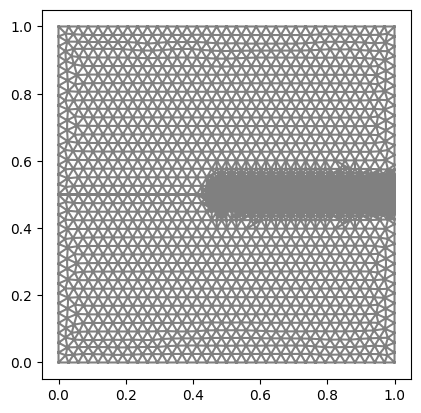

In [5]:
while mesh.hmin() > l / 3:
    zone_of_refinement = CompiledSubDomain("x[0]>0.45 && x[1]>0.45 && x[1]<0.55")
    markers = MeshFunction("bool", mesh, mesh.topology().dim(), 0)
    zone_of_refinement.mark(markers, True)
    mesh = refine(mesh, markers)
plot(mesh)
mesh.num_vertices()

In [6]:
top = CompiledSubDomain("on_boundary && near(x[1], 1.0)")
bottom = CompiledSubDomain("on_boundary && near(x[1], 0.0)")
V = VectorFunctionSpace(mesh, "CG", 1)
F = FunctionSpace(mesh, "CG", 1)
DG0 = FunctionSpace(mesh, "DG", 0)

u, v = TrialFunction(V), TestFunction(V)
uold, unew = Function(V), Function(V, name="Displacement")

p, q = TrialFunction(F), TestFunction(F)
pold, pnew = Function(F), Function(F, name="PhaseField")

cdfold, cdfnew = Function(DG0), Function(DG0, name="CrackDrivingForce")

applied_traction = Expression("max_disp*t", max_disp=max_disp, t=0.0, degree=2)
bc_support = DirichletBC(V, Constant((0.0, 0.0)), bottom)
bc_load = DirichletBC(V.sub(1), applied_traction, top)

bc_u = [bc_support, bc_load]
bc_phi = []

top_marker = 2
mf_facet = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
mf_facet.set_all(0)
top.mark(mf_facet, top_marker)
a_u = ((1 - pold) ** 2 + 1e-8) * inner(sigma(u, lmbda, mu), epsilon(v)) * dx
L_u = dot(Constant((0.0, 0.0)), v) * dx

a_p = Gc * ((p * q) / l + l * inner(grad(p), grad(q))) * dx + 2 * p * q * cdfnew * dx
L_p = 2 * cdfnew * q * dx
# -------------------------------------------------------------------------------------------------
# DEFINE LINEAR VARIATIONAL PROBLEMS ---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------
problem_disp = LinearVariationalProblem(a_u, L_u, unew, bc_u)
solver_disp = LinearVariationalSolver(problem_disp)

problem_dmg = LinearVariationalProblem(a_p, L_p, pnew)
solver_dmg = LinearVariationalSolver(problem_dmg)

columns = ["Time", "Disp", "Force", "Itr", "Error", "Wall Time"]
w = [10, 12, 10, 8, 12, 8]

print("".join(f"{c:<{x}}" for c, x in zip(columns, w)))
print("-" * (sum(w) + 3))

start_time_wall = time.time()
current_time = 0.0

displacement_data = []
force_data = []


while current_time <= end_time:
    current_time += dt
    applied_traction.t = current_time
    am_iter = 0
    err = 1
    while err > toll:
        am_iter += 1
        solver_disp.solve()
        cdfnew.assign(project(ufl.Max(psi_plus(unew, lmbda, mu), cdfold), DG0))
        solver_dmg.solve()

        err_u = assemble(inner(unew - uold, unew - uold) * dx) ** 0.5
        err_phi = assemble(inner(pnew - pold, pnew - pold) * dx) ** 0.5
        err = max(err_u, err_phi)

        force = reaction_force(unew, pnew, mf_facet, lmbda, mu, top_marker)
        iter_time_wall = time.time() - start_time_wall

        xdmf_file.write(unew, current_time)
        xdmf_file.write(pnew, current_time)
        xdmf_file.write(cdfnew, current_time)

        # Print data row (formatted)
        print(
            f"{current_time:<{w[0]}.5f}"
            f"{current_time * max_disp:<{w[1]}.6f}"
            f"{force:<{w[2]}.3f}"
            f"{am_iter:<{w[3]}d}"
            f"{err:<{w[4]}.3e}"
            f"{iter_time_wall:<{w[5]}.2f}"
        )
        displacement_data.append(current_time * max_disp)
        force_data.append(force)

        uold.assign(unew)
        pold.assign(pnew)
        cdfold.assign(cdfnew)
print("Simulation completed")

Time      Disp        Force     Itr     Error       Wall Time
---------------------------------------------------------------
0.00250   0.000020    2.764     1       1.270e-05   0.16    
0.00250   0.000020    2.764     2       1.348e-12   0.30    
0.00500   0.000040    5.527     1       1.270e-05   0.41    
0.00500   0.000040    5.527     2       8.089e-12   0.55    
0.00750   0.000060    8.291     1       1.270e-05   0.66    
0.00750   0.000060    8.291     2       2.022e-11   0.80    
0.01000   0.000080    11.055    1       1.270e-05   0.92    
0.01000   0.000080    11.055    2       4.934e-11   1.07    
0.01250   0.000100    13.818    1       1.270e-05   1.22    
0.01250   0.000100    13.818    2       9.912e-11   1.36    
0.01500   0.000120    16.582    1       1.270e-05   1.48    
0.01500   0.000120    16.582    2       1.745e-10   1.62    
0.01750   0.000140    19.345    1       1.270e-05   1.74    
0.01750   0.000140    19.345    2       2.806e-10   1.88    
0.02000   0.000160  

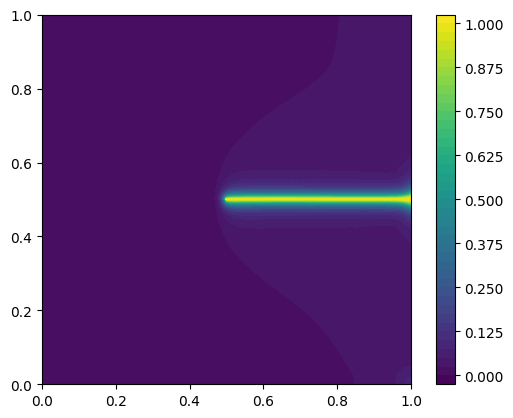

In [7]:
p = plot(pnew)
plt.colorbar(p)

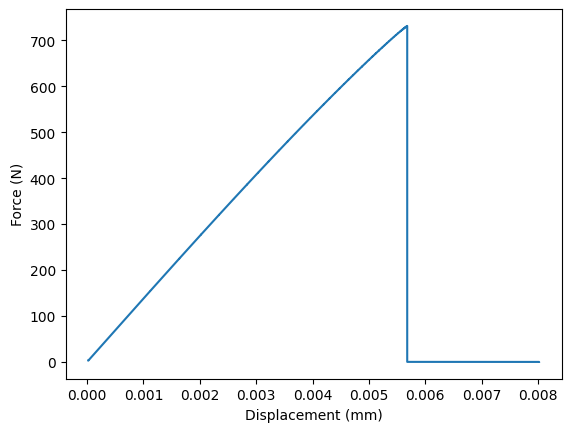

In [10]:
plt.plot(displacement_data, force_data)
plt.xlabel("Displacement (mm)")
plt.ylabel("Force (N)")
plt.show()